In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn
from sklearn.neighbors import NearestNeighbors

## Create lorentz time series

In [58]:
# Parameters
T=4000 #sequence size
sigma=10
beta=8/3
rho=28
dt=0.01

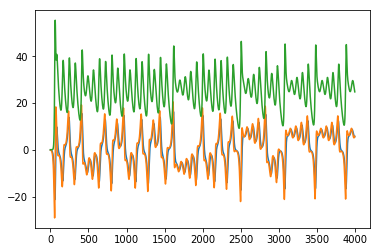

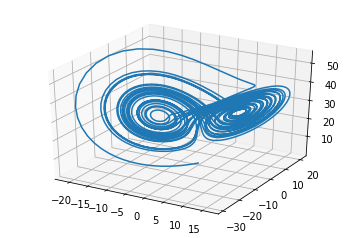

In [59]:
x=np.zeros((T+1))
y=np.zeros((T+1))
z=np.zeros((T+1))
x[0]=0.2*(np.random.rand()-0.5)
y[0]=0.2*(np.random.rand()-0.5)
z[0]=0.2*(np.random.rand()-0.5)

for i in range(T):
    x[i+1]=x[i]+dt*sigma*(y[i]-x[i])
    y[i+1]=y[i]+dt*(x[i]*(rho-z[i])-y[i])
    z[i+1]=z[i]+dt*(x[i]*y[i]-beta*z[i])

fig=plt.figure()
ax=fig.add_subplot(111)
ax.plot(x)
ax.plot(y)
ax.plot(z)

fig2=plt.figure()
ax2=fig2.add_subplot(111,projection='3d')
ax2.plot(x,y,z)

### Create shadow manifold for X,Y and Z

In [67]:
E=2
tau=2
L=30 # number of samples from the time series sequence

In [68]:
def build_shadow_M (X,tau,E,T):
    '''Build the shadow manifold of the time series signal X, with E variables and sampling tau'''
    shadow_M=np.zeros((T-E+1,E))
    for i in range((tau*E-1),T):
        sample=np.zeros((E))
        for j in range(0,E):
            sample[j]=x[i-j*tau]
        shadow_M[i-(tau*E-1),:]=sample
    return shadow_M

In [72]:
shadow_x=build_shadow_M(x,tau,E,T)
shadow_y=build_shadow_M(y,tau,E,T)
shadow_z=build_shadow_M(z,tau,E,T)

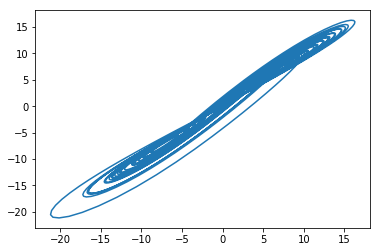

In [79]:
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#ax.plot(shadow_x[:,0],shadow_x[:,1],shadow_x[:,2])

fig = plt.figure()
plt.plot(shadow_x[:,0],shadow_x[:,1])

### Sample the random manifold
Selec the value L, that reflects the number of points of the reconstructed manifold

In [64]:
L=10
def sample_manifold (M, L):
    '''Randomly select L points from the shadow manifold M'''
    new_M=np.zeros((L,M.shape[1]))
    idx=np.random.randint(M.shape[0], size=L)
    for i in range(L):
        new_M[i,:]=M[idx[i],:]
    return new_M
            

In [65]:
recon_Mx=sample_manifold(shadow_x,L)
recon_My=sample_manifold(shadow_y,L)
recon_Mz=sample_manifold(shadow_z,L)

### Find E+1 nearest neighbors

In [49]:
nbrs=NearestNeighbors(n_neighbors=E+1,algorithm='auto').fit(shadow_x)
distances, indices=nbrs.kneighbors(shadow_x)

# the first index is the point itself at distance 0

In [50]:
indices

array([[  0,   1,  12,  13],
       [  1,   2,   0,  10],
       [  2,   3,   1,   9],
       ...,
       [995, 828, 188, 667],
       [996, 668, 829, 349],
       [997, 191, 831, 351]])

In [454]:
# translate indices to time indices
for i in range(len(indices)):
    for j in range(len(indices[i])):
        indices[i,j]=idx[indices[i,j]]

In [455]:
indices

array([[414, 810, 984, 908],
       [652, 651, 491, 317],
       [287, 132, 999, 610],
       [754, 347, 548, 547],
       [377, 930, 931, 999],
       [491, 317, 556, 347],
       [773, 230, 855, 908],
       [347, 754, 556, 317],
       [999, 287, 132, 377],
       [984, 908, 855, 773],
       [419, 810, 414, 984],
       [855, 773, 908, 230],
       [230, 773, 855, 908],
       [651, 652, 491, 317],
       [317, 556, 347, 491],
       [ 70, 651, 652, 491],
       [625, 534, 547, 548],
       [534, 625, 547, 548],
       [930, 931, 223, 274],
       [223, 931, 930, 274],
       [908, 855, 773, 230],
       [810, 419, 414, 984],
       [548, 547, 625, 534],
       [547, 548, 625, 534],
       [132, 287, 999, 610],
       [305, 610, 534, 625],
       [610, 305, 534, 132],
       [274, 223, 931, 930],
       [556, 317, 347, 491],
       [931, 930, 223, 274]])

### Compute predicted values

In [456]:
distances

array([[ 0.        ,  3.58356357,  3.81372559,  5.32672767],
       [ 0.        ,  0.20352639,  5.84508688,  7.77928693],
       [ 0.        ,  0.71009891,  0.88279553,  3.37050597],
       [ 0.        ,  1.16066574,  1.85655378,  1.9266972 ],
       [ 0.        ,  2.74752216,  2.84369924,  2.94747939],
       [ 0.        ,  1.94047968,  2.11281512,  3.14424634],
       [ 0.        ,  0.37550508,  0.5124661 ,  1.20062686],
       [ 0.        ,  1.16066574,  1.45941173,  1.75122165],
       [ 0.        ,  0.88279553,  1.59069883,  2.94747939],
       [ 0.        ,  1.96954474,  2.64600113,  3.13975618],
       [ 0.        ,  2.15587754,  5.51054062,  9.05809097],
       [ 0.        ,  0.5124661 ,  0.76375129,  0.88648257],
       [ 0.        ,  0.37550508,  0.88648257,  1.56112966],
       [ 0.        ,  0.20352639,  6.02000892,  7.95154936],
       [ 0.        ,  0.29364123,  1.75122165,  1.94047968],
       [ 0.        , 14.13648376, 14.32528363, 20.11366334],
       [ 0.        ,  0.

In [457]:
# compute weights

weights_u=np.zeros((L,E))
for i in range(L):
    for j in range(1,E+1):
        weights_u[i,j-1]= np.exp(-distances[i,j]/distances[i,1])
        

In [458]:
weights_u

array([[3.67879441e-01, 3.44994386e-01, 2.26177963e-01],
       [3.67879441e-01, 3.36876177e-13, 2.51293045e-17],
       [3.67879441e-01, 2.88459437e-01, 8.68176623e-03],
       [3.67879441e-01, 2.01985495e-01, 1.90140279e-01],
       [3.67879441e-01, 3.55224595e-01, 3.42057203e-01],
       [3.67879441e-01, 3.36616580e-01, 1.97830457e-01],
       [3.67879441e-01, 2.55447565e-01, 4.08697476e-02],
       [3.67879441e-01, 2.84394783e-01, 2.21173479e-01],
       [3.67879441e-01, 1.64987068e-01, 3.54794407e-02],
       [3.67879441e-01, 2.60941703e-01, 2.03080410e-01],
       [3.67879441e-01, 7.76103442e-02, 1.49719094e-02],
       [3.67879441e-01, 2.25294912e-01, 1.77313394e-01],
       [3.67879441e-01, 9.43471857e-02, 1.56479887e-02],
       [3.67879441e-01, 1.42630750e-13, 1.07794980e-17],
       [3.67879441e-01, 2.57009103e-03, 1.34907612e-03],
       [3.67879441e-01, 3.62998889e-01, 2.41033488e-01],
       [3.67879441e-01, 1.37843795e-01, 8.11518345e-02],
       [3.67879441e-01, 7.50750

In [459]:
weights_w=np.zeros((L,E))
for i in range(L): 
    weights_w[i,:]=weights_u[i,:]/(sum(weights_u[i,:]))

In [460]:
# check is sum is 1
boole=True 
for i in range(L):
    boole=boole&(sum(weights_w[i,:])-1.0<0.000001)
print (boole)

True


In [461]:
shadow_y_pred=np.zeros((L,E))
for i in range(L):
    # for each point in the shadow manifold
    for j in range(1,E+1):
            shadow_y_pred[i,:]=shadow_y_pred[i,:]+weights_w[i,j-1]*shadow_y[indices[i,j],:]

IndexError: index 999 is out of bounds for axis 0 with size 999

In [462]:
shadow_y_pred

array([[ 3.15846188,  3.31949649,  3.49839471],
       [-8.29849096, -9.16080025, -9.98624074],
       [-1.77233932, -1.69884848, -1.63236202],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.   

In [463]:
shadow_y_target=[]
for i in idx:
    sample=[x[i],x[i-tau],x[i-2*tau]]
    shadow_y_target.append(sample)

In [464]:
shadow_y_target

[[8.15811700704811, 7.580734528502523, 7.037299027603104],
 [-11.521839364732557, -11.692461434152792, -11.796573140175022],
 [-1.7610325923264725, -1.6116051009169574, -1.4474095213218607],
 [-4.9540550977684905, -6.03877306810508, -7.166804769123887],
 [0.6375661359805554, 0.5941564125344185, 0.5505363069317875],
 [-8.44591680004399, -8.305161748760604, -8.15927444545779],
 [4.181158371851913, 4.04261544716848, 3.8900981886475337],
 [-5.967490280649056, -6.598815353097189, -7.247096267018778],
 [-1.2780055719123629, -1.1041100944853446, -0.9103232465802444],
 [4.904591901820008, 5.672252160531009, 6.474473742529167],
 [11.470693105273941, 10.76688428952555, 10.0772574463469],
 [4.409896118117823, 4.324456045464307, 4.251852830196958],
 [4.05400031394271, 3.8249734436687715, 3.6117695117646904],
 [-11.692461434152792, -11.796573140175022, -11.834937896983327],
 [-7.563163291776084, -7.192517143592891, -6.83706809846538],
 [-20.71120319590107, -19.97802622882108, -19.015905479996864],


### Compute correlation between predicted and target

In [465]:
mean_pred=np.mean(shadow_y_pred,0) # compute the mean
mean_target=np.mean(shadow_y_target,0)
std_pred=np.std(shadow_y_pred,0) # compute the standard deviation
std_target=np.std(shadow_y_target,0)

In [466]:
corr=0
for i in range(L):
    corr=corr+np.corrcoef(shadow_y_pred[i,:],np.array(shadow_y_target)[i,:])
corr=corr/L

/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [467]:
corr

array([[nan, nan],
       [nan,  1.]])